## Full MLP Implementation

### Step 2.1 — Import Libraries

In [2]:

import torch                                  
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


### Step 2.2 — Load MNIST Dataset

What is MNIST?
MNIST = Modified National Institute of Standards and Technology

70,000 handwritten digits (0-9)

Each image: 28×28 pixels (784 total pixels)

Grayscale (1 channel) [RGB is 3 channel]

What ToTensor() does:
Converts PIL Image or numpy array to PyTorch tensor

Scales pixel values from [0, 255] to [0.0, 1.0]

Changes shape from (H, W) to (C, H, W) → (1, 28, 28) [1 means grayscale]

Before transform:
```
Image: PIL Image object 
Pixel values: 0-255 (integers) 
Shape: (28, 28)
```
After transform:
```
Tensor: torch.Tensor
Pixel values: 0.0-1.0 (floats)
Shape: (1, 28, 28)
```



In [9]:
transform = transforms.ToTensor()                   # Convert PIL images to PyTorch tensors and normalize pixel values to [0, 1]

train_dataset = torchvision.datasets.MNIST(         # Load MNIST dataset
    root='./data',                                  # Directory to store/download dataset
    train=True,                                     # Load training set (60,000 images) for training among the 70,000 total images
    transform=transform,                            # Apply ToTensor() to each image 
    download=True                                   # Download dataset if it doesn't exist
)

# What this creates:
# train_dataset is a PyTorch Dataset object

# Contains 60,000 tuples: (image_tensor, label)

# image_tensor.shape = (1, 28, 28)     # 1 channel (grayscale), 28x28 pixels; 1 channel because MNIST images are grayscale (not RGB), so we have a single channel; 28x28 is the size of each image

# label = integer 0-9

# Structure of train_dataset:
# train_dataset[0] = (tensor of digit 5, 5)  # 5 is the label, tensor of digit 5 is the image data which is a 1x28x28 tensor; The first element of the tuple is the image tensor, and the second element is the corresponding label (the digit that the image represents)
# train_dataset[1] = (tensor of digit 0, 0)
# train_dataset[2] = (tensor of digit 4, 4)
# ...

test_dataset = torchvision.datasets.MNIST(           # Load MNIST dataset
    root='./data',                                   # Directory to store/download dataset
    train=False,                                     # Load test set (10,000 images) for evaluation or testing among the 70,000 total images which is separate from the training set and never seen by the model during training
    transform=transform                              # Apply ToTensor() to each image
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True)   # Create a DataLoader object to load the training data in batches

# What is DataLoader?
# A DataLoader wraps a Dataset and provides:
# Batching: Groups images into batches
# Shuffling: Randomizes order each epoch (important for training)
# Parallel loading: Uses multiple CPU cores
# Memory efficient: Loads data on-the-fly, not all at once

# Parameters explained:
# Parameter	      Value	            What it does
# batch_size	  64	            64 images per batch
# shuffle	      True/False	    Randomize order (True for training, False for testing (for testing shuffling is not necessary))

# What happens inside train_loader:
# Original dataset: [img0, img1, img2, ..., img59999]
# After shuffling: [img423, img12876, img5, img38902, ...]

# Batching: 
# Batch 0: images 423, 12876, 5, 38902, ... (64 images)
# Batch 1: next 64 images
# ...
# Batch 937: last 64 images (since 60000/64 = 937.5 → 938 batches)
# Batch 0 shape:
# images.shape = (64, 1, 28, 28)   # 64 images, 1 channel, 28x28 pixels
# labels.shape = (64,)             # 64 integers labels corresponding to the 64 images in the batch

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False)  # Create a DataLoader object to load the test data in batches; shuffle=False because we don't need to randomize order for evaluation/testing



### KEY TAKEAWAYS
```
Why Batch?
Speed: Process multiple images at once

Stability: Average gradients are less noisy

Efficiency: Utilize GPU parallelization

Why 64?
Power of 2: Optimized for computer hardware

Memory sweet spot: Fits well in GPU

Good balance: Stable gradients, fast training

Why Shuffle?
Prevents order bias: Model doesn't learn dataset order

Better generalization: Sees mixed examples

Stable training: Avoids dramatic weight swings
```

### Step 2.3 — Define the MLP Model



In [4]:
class MLP(nn.Module):                            # Define a Multilayer Perceptron (MLP) class that inherits from nn.Module class, which is the base class for all neural network modules in PyTorch
    def __init__(self):                          # Constructor method to initialize the layers of the MLP
        super(MLP, self).__init__()              # Call the constructor of the parent class (nn.Module) to properly initialize the MLP class
        self.model = nn.Sequential(              # Create a sequential container to hold the layers of the MLP
            nn.Flatten(),                        # Flatten the input images from (1, 28, 28) to (1, 28*28) = (1, 784) so that it can be fed into the linear layers because linear layers expect 1D input, so now it creates 784 inputs
            nn.Linear(28*28, 128),               # Linear layer with 28*28 (784) inputs and 128 outputs which means it will learn 128 features from the input image
            nn.ReLU(),                           # ReLU activation function to introduce non-linearity, allowing the model to learn more complex patterns
            nn.Linear(128, 64),                  # Linear layer with 128 inputs and 64 outputs which means it will learn 64 features from the previous layer's 128 features
            nn.ReLU(),
            nn.Linear(64, 10)                    # Linear layer with 64 inputs and 10 outputs which means it will learn to classify the input into 10 classes (digits 0-9)
        )

    def forward(self, x):                        # Define the forward pass of the MLP, which takes an input tensor x and passes it through the layers defined in self.model
        return self.model(x)                     # Return the output of the model after passing the input through all the layers; This will be a tensor of shape (batch_size, 10) containing the raw scores (logits) for each of the 10 classes for each image in the batch

model = MLP()                                    # Create an instance of the MLP class, which initializes the model with the defined architecture


```
Why create a class?
Inherits from nn.Module (gets all PyTorch functionality)

__init__: Defines the architecture (layers)

forward: Defines how data flows through layers

Layer-by-layer breakdown:
Layer 1: nn.Flatten()
Purpose: Convert 2D image (1,28,28) to 1D vector (784)

Before Flatten:


Input shape: (64, 1, 28, 28)  # batch, channels, height, width
Values: 28×28 grid of pixels
After Flatten:


Output shape: (64, 784)  # batch, flattened features
Values: [pixel0, pixel1, ..., pixel783]            ; these are total 784 inputs from 64 images of a batch
Why flatten? MLP expects 1D input, not 2D images.

Layer 2: nn.Linear(784, 128)
Purpose: First hidden layer with 128 neurons;  784 inputs to 128 neurons

What it contains:

Weight matrix: 128 × 784 = 100,352 parameters

Bias vector: 128 parameters

Total: 100,480 parameters in this layer alone!

Mathematical operation:


h₁ = W₁ × flattened_input + b₁
Shape: (64, 128) = (64, 128) × (64, 784)ᵀ? No, careful:

Input shape: (64, 784)  
W1 shape: (128, 784)
Output = Input @ W1.T + b1
Shape: (64, 128) = (64, 784) @ (784, 128) + (128,)
Layer 3: nn.ReLU()
Purpose: Add non-linearity

What it does:


ReLU(x) = max(0, x)

Before ReLU: [-0.5, 1.2, -3.1, 4.0]
After ReLU:  [0.0,  1.2,  0.0, 4.0]
Why? Without ReLU, stacking linear layers is still linear!

Layer 4: nn.Linear(128, 64)
Purpose: Second hidden layer with 64 neurons

Parameters:

Weight matrix: 64 × 128 = 8,192 parameters

Bias vector: 64 parameters

Total: 8,256 parameters

Layer 5: nn.ReLU()
Same as before, adds non-linearity.

Layer 6: nn.Linear(64, 10)
Purpose: Output layer with 10 neurons (one per digit 0-9)

Parameters:

Weight matrix: 10 × 64 = 640 parameters

Bias vector: 10 parameters

Total: 650 parameters

Output shape: (64, 10) → 64 samples, each with 10 values (logits)

Total parameters:

Layer 1: 100,480
Layer 2: 8,256
Layer 3: 650
Total: 109,386 learnable parameters!
```

### Step 2.4 — Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()                          # CrossEntropy penalizes wrong confident predictions more; Define the loss function as CrossEntropyLoss, which is commonly used for multi-class classification problems; It combines LogSoftmax and NLLLoss (negative log likelihood loss funstion) in one single class, making it suitable for our 10-class classification task (digits 0-9), criterion will compute the loss between the predicted logits from the model and the true labels for each batch of data during training
optimizer = optim.Adam(model.parameters(), lr=0.001)       # Define the optimizer as Adam, which is an adaptive learning rate optimization algorithm that is widely used for training neural networks; It adjusts the learning rate for each parameter based on the first and second moments of the gradients, allowing for efficient training; lr=0.001 sets the initial learning rate for the optimizer


```
What is CrossEntropyLoss?
Combines LogSoftmax + NLLLoss (Negative Log Likelihood) in one class.

Step-by-step what it does:

1. Input to CrossEntropyLoss:

Raw model outputs (logits): shape (64, 10)

Values can be anything (-∞ to +∞)

2. Applies Softmax internally:


softmax(x_i) = exp(x_i) / sum(exp(x_i))

Example:
logits = [2.0, 1.0, 0.1]     # Raw model outputs
exp: [7.39, 2.72, 1.11]
sum = 11.22
softmax: [0.66, 0.24, 0.10]  # Probabilities summing to 1
3. Computes negative log likelihood:


loss = -log(probability_of_correct_class)


Correct class = 0, probability = 0.66
loss = -log(0.66) = 0.42

If model was confident and wrong:
Correct class = 1, probability = 0.24    # wrong 
loss = -log(0.24) = 1.43  # Higher loss!
Why not use MSE?

CrossEntropy penalizes wrong confident predictions more

Works better with probability outputs

Gradient doesn't vanish near 0/1

python:
optimizer = optim.Adam(model.parameters(), lr=0.001)
What is Adam?
Adam = Adaptive Moment Estimation

Why Adam instead of SGD?
Adaptive learning rates: Different learning rates for different parameters

Momentum: Remembers past gradients to smooth updates

Works well out-of-the-box: Less hyperparameter tuning

What Adam does internally:
For each parameter:


1. Compute gradient: g_t
2. Update biased first moment estimate: m_t = β₁×m_{t-1} + (1-β₁)×g_t
3. Update biased second moment estimate: v_t = β₂×v_{t-1} + (1-β₂)×g_t²
4. Bias correction
5. Update: θ_t = θ_{t-1} - lr × m_t / (√v_t + ε)
Parameters:
lr=0.001: Learning rate (default for Adam, works well)

betas=(0.9, 0.999): Decay rates for moments (default)

eps=1e-8: Small number to avoid division by zero
```

### Step 2.5 — Training Loop

In [6]:
epochs = 5                       # total 938 batches of 60000 images will be passed 5 times; Number of times to loop through the entire training dataset during training; More epochs can lead to better learning but also increases training time and risk of overfitting
losses = []                      # List to store loss values for each epoch, which can be used for plotting the training loss curve after training is complete

for epoch in range(epochs):
    running_loss = 0.0           # Initialize running_loss to 0 at the start of each epoch; This variable will be used to accumulate the loss for all batches in the current epoch, allowing us to compute the average loss at the end of the epoch for monitoring training progress 
                                 # Variable to accumulate the loss for the current epoch; example: if we have 938 batches in each epoch and the loss for each batch is computed, running_loss will sum up all those batch losses, and at the end of the epoch, we will divide running_loss by the number of batches (len(train_loader)) to get the average loss for that epoch
    
    for images, labels in train_loader:          # Loop over the batches in the training dataset 
        outputs = model(images)                  # Forward pass:(10 outputs) Pass the input images through the model to get the predicted outputs (logits) for each class; outputs will have shape (batch_size, 10) containing the raw scores for each of the 10 classes for each image in the batch
        loss = criterion(outputs, labels)        # Compute the loss by comparing the predicted outputs (logits) with the true labels using the defined loss function (criterion); This will give us a single scalar value representing how well the model's predictions match the true labels for the current batch of data
        
        optimizer.zero_grad()                    # Zero the gradients of the model's parameters before performing backpropagation; This is important because by default, PyTorch accumulates gradients on subsequent backward passes, so we need to clear the old gradients before computing the new ones for the current batch
        loss.backward()                          # Backward pass: Compute the gradients of the loss with respect to the model's parameters using backpropagation; This will populate the .grad attributes of each parameter in the model with the computed gradients based on the current batch's loss
        optimizer.step()                         # Update the model's parameters using the computed gradients; This will adjust the weights of the model in the direction that minimizes the loss, based on the optimization algorithm (Adam in this case) and the learning rate
        
        running_loss += loss.item()              # Accumulate the loss for the current batch into running_loss; loss.item() extracts the scalar value from the loss tensor, allowing us to keep a running total of the loss for all batches in the current epoch
    
    epoch_loss = running_loss / len(train_loader)    # Compute the average loss for the epoch by dividing the accumulated running_loss by the number of batches (len(train_loader)); This gives us a single scalar value representing the average loss for that epoch, which can be used to monitor training progress and convergence
    losses.append(epoch_loss)                        # Append the average loss for the current epoch to the losses list, which can be used later for plotting the training loss curve to visualize how the loss changes over epochs
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")    # Print the epoch number and the average loss for that epoch formatted to 4 decimal places; This provides feedback on the training process, allowing us to see how the loss decreases over time as the model learns from the training data


Epoch 1, Loss: 0.3492
Epoch 2, Loss: 0.1399
Epoch 3, Loss: 0.0957
Epoch 4, Loss: 0.0704
Epoch 5, Loss: 0.0551


#### line by line explained
```
python
epochs = 5
losses = []
What's an epoch?
One complete pass through ALL 60,000 training images.

Why 5 epochs?

MNIST is simple, learns quickly

More epochs might overfit

5 is enough to see learning

python
for epoch in range(epochs):
    running_loss = 0.0
running_loss accumulates loss for this epoch

Reset to 0 at start of each epoch

python
    for images, labels in train_loader:
What happens in one iteration:
Data shapes:

images.shape: (64, 1, 28, 28)

labels.shape: (64,)

python
        outputs = model(images)
Forward pass through all layers:

Flatten: (64, 1, 28, 28) → (64, 784)

Linear(784→128): (64, 784) → (64, 128)

ReLU: (64, 128) → (64, 128) (negative values become 0)

Linear(128→64): (64, 128) → (64, 64)

ReLU: (64, 64) → (64, 64)

Linear(64→10): (64, 64) → (64, 10)

Final outputs: Raw scores (logits) for each of 10 digits

python
        loss = criterion(outputs, labels)
What happens inside criterion:


loss = 0
for i in range(64):  # Each image in batch
    # Get probability of correct class using softmax
    prob_correct = softmax(outputs[i])[labels[i]]
    # Add negative log probability to loss
    loss += -log(prob_correct)

loss = loss / 64  # Average over batch
Example for one image:


Outputs = [2.1, 0.5, -1.2, 3.4, 0.1, -0.8, 1.2, -2.1, 0.9, -0.3]
Label = 3 (digit 3)

Softmax probabilities:
[0.08, 0.03, 0.01, 0.30, 0.02, 0.01, 0.03, 0.00, 0.02, 0.00]

Probability of class 3 = 0.30
Loss = -log(0.30) = 1.20
python
        optimizer.zero_grad()
Why? Gradients accumulate by default. Without zeroing:


Batch 1: grad = 0.1
Batch 2: grad = 0.1 + 0.2 = 0.3  ← WRONG!
Batch 3: grad = 0.1 + 0.2 + 0.3 = 0.6  ← EVEN WORSE!
What it does:

python
for param in model.parameters():
    if param.grad is not None:
        param.grad.zero_()
python
        loss.backward()
Computes gradients for ALL 109,386 parameters!

What happens internally:

Starts at loss (scalar)

Traverses computation graph backwards

Applies chain rule at each node

Stores gradients in param.grad

Example gradient path:


loss ← CrossEntropy ← Linear(64→10) ← ReLU ← Linear(128→64) ← ReLU ← Linear(784→128) ← Flatten ← images
   ↑              ↑         ↑            ↑         ↑            ↑         ↑                ↑
   ∂L/∂logits    ∂logits/∂h3  ∂h3/∂a2   ∂a2/∂h2   ∂h2/∂a1    ∂a1/∂h1   ∂h1/∂flattened  ∂flattened/∂images
python
        optimizer.step()
Updates all parameters using gradients:

python
for param in model.parameters():
    # Adam update rule (simplified)
    param.data = param.data - learning_rate * adjusted_gradient
Example for one weight:


Before: weight = 0.5
Gradient: -0.02
Learning rate: 0.001

After: weight = 0.5 - 0.001 × (-0.02) = 0.5 + 0.00002 = 0.50002
python
        running_loss += loss.item()
loss.item() converts PyTorch tensor to Python float

Adds to running total for this epoch

python
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
len(train_loader) = number of batches (60000/64 = 938)

Average loss for the epoch

Store for plotting

Print progress
```

### Step 2.6 — Plot Loss

What to look for:

Decreasing: Model learning

Plateau: Might need more epochs or different learning rate

Increasing: Something wrong (learning rate too high)


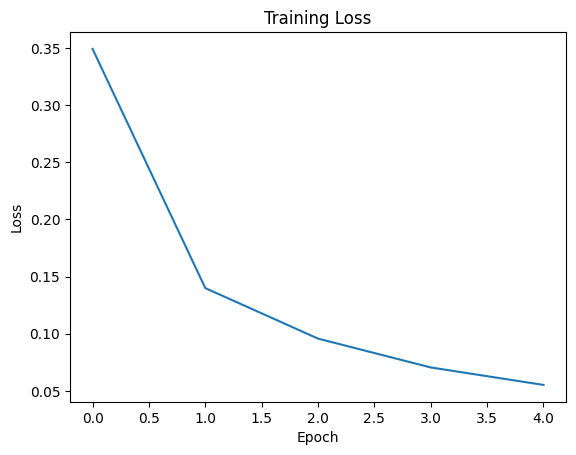

In [7]:
plt.plot(losses)           # Plot the training loss curve using the losses list, which contains the average loss for each epoch; This will help visualize how the loss changes over epochs, allowing us to see if the model is converging (loss decreasing) or if there are issues like overfitting (loss decreasing and then increasing) where x-axis represents the epoch number and y-axis represents the average loss for that epoch
plt.xlabel("Epoch")        # Label the x-axis as "Epoch"
plt.ylabel("Loss")         # Label the y-axis as "Loss"
plt.title("Training Loss") 
plt.show()                 # Display the plot


### Step 2.7 — Test Accuracy

In [8]:
correct = 0                                               # Initialize a variable to count the number of correct predictions made by the model on the test dataset; This will be used to calculate the accuracy of the model after evaluating it on the test data
total = 0                                                 # Initialize a variable to count the total number of predictions made by the model on the test dataset; This will be used as the denominator when calculating accuracy, which is the ratio of correct predictions to total predictions 

with torch.no_grad():                                     # Use torch.no_grad() to disable gradient computation during evaluation; This is important because we don't need gradients for evaluation, and it can save memory and computation time
    for images, labels in test_loader:                    # Loop over the batches in the test dataset
        outputs = model(images)                           # Forward pass: Pass the input images through the model to get the predicted outputs (logits) for each class
        _, predicted = torch.max(outputs, 1)              # Get the predicted class by taking the index of the maximum logit for each image in the batch; torch.max(outputs, 1) returns both the maximum values and their indices along dimension 1 (the class dimension), and we use _ to ignore the max values and keep only the predicted class indices in predicted
        total += labels.size(0)                           # Increment the total count by the number of labels in the current batch (labels.size(0) gives the batch size, which is the number of images in that batch); This keeps track of how many predictions we have made in total across all batches in the test dataset
        correct += (predicted == labels).sum().item()     # Increment the correct count by the number of correct predictions in the current batch; (predicted == labels) creates a boolean tensor where True indicates a correct prediction, and .sum() counts the number of True values (correct predictions) in that batch; .item() converts the resulting tensor to a Python scalar and adds it to the correct count

print("Accuracy:", 100 * correct / total, "%")            # Calculate and print the accuracy of the model on the test dataset; Accuracy is computed as (correct / total) * 100 to get a percentage, which indicates how well the model performs on unseen data (the test set) after training; A higher accuracy means the model is better at correctly classifying the digits in the test dataset


Accuracy: 97.38 %


```
python
correct = 0
total = 0
Initialize counters for correct predictions and total samples.

python
with torch.no_grad():
Why torch.no_grad()?

Disables gradient computation

Saves memory and computation

We don't need gradients for testing

Without this:

PyTorch would build computation graph for every test image

Wastes memory and time

python
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
Breaking down the loop:
1. Get batch:

images.shape: (64, 1, 28, 28)

labels.shape: (64,)

2. Forward pass:

outputs.shape: (64, 10) → logits for each class

3. torch.max(outputs, 1):


outputs = [[2.1, 0.5, -1.2, 3.4, ...],  # Image 1
           [0.1, 4.2, -0.8, 1.2, ...],  # Image 2
           ...]

torch.max returns:
values = [3.4, 4.2, ...]  # Maximum values
indices = [3, 1, ...]      # Positions of maxima (the predicted digits)
We only need indices (predicted digits), so _, predicted.

4. total += labels.size(0):

labels.size(0) = batch size (64)

Keep running total of images processed

5. (predicted == labels):


predicted = [3, 1, 7, 0, 4, ...]
labels    = [3, 1, 9, 0, 4, ...]
Comparison = [True, True, False, True, True, ...]
6. .sum().item():

.sum() counts True values → tensor

.item() converts to Python integer

python
print("Accuracy:", 100 * correct / total, "%")
Example:


correct = 9,750
total = 10,000
accuracy = 100 × 9750/10000 = 97.5%
Typical MNIST accuracy: 97-98% with this simple MLP
```